# Paper Figures Notebook

In [1]:
%cd C:/Luke/PhD/paper2/SRvey/
# Import and setup tiles / inference outputs used throughout notebook
from pathlib import Path

import colorcet as cc
from comet_ml.api import APIExperiment
import matplotlib.pyplot as plt
import numpy as np
import numpy.fft as fft
import tifffile
import torch
import torchvision.transforms as T
import rasterio
from mpl_toolkits.axes_grid1 import make_axes_locatable as mplax

# from sklearn.preprocessing import PowerTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

exp_id = "a80b21acfa61499bbf384c0629e41e80"
epoch_to_load = "latest"
sample_tile_index = 0
test_dir = "data/inference/"
model_dir = "data/models/"

tp = Path(test_dir)
assert tp.exists(), f"Directory {tp.absolute()} not found"
# tr = tp.parts[-3]
# input_hr = np.load(next(tp.glob("HR_tiles.npy")), mmap_mode="c").astype(np.float64)
# input_lr = np.load(next(tp.glob("LR_tiles.npy")), mmap_mode="c").astype(np.float64)
# print(f"You had {len(input_hr)} tiles to choose from.")

full_models = sorted(list(next(Path(model_dir).glob(f"*{exp_id}*")).glob("**/*.tar*")))
print(f"You had {len(full_models)} full models to choose from.")
checkpoints = sorted(list(next(Path(model_dir).glob(f"*{exp_id}*")).glob("**/*.pth*")))
print(f"You had {len(checkpoints)/2} generator checkpoints to choose from.")
model = sorted(
    [p for p in full_models if str(epoch_to_load) in str(p)[-7:]]
)  # G and D, select G
g_pth = sorted([p for p in checkpoints if str(epoch_to_load) in str(p)[-7:]])

out_dir = Path("data/figures")
device = "cuda"


def upscale(im, us_method="nearest"):
    return torch.nn.functional.interpolate(im, scale_factor=4, mode=us_method)


C:\Luke\PhD\paper2\SRvey
You had 0 full models to choose from.
You had 1.5 generator checkpoints to choose from.


In [2]:
def plot_vis_comp(
    lr,
    us,
    rdn_sr,
    egp_sr,
    hr=None,
    lr_only=False,
    figname="Visual Comparisons",
    out_dir="data/figures",
):

    # Some inference won't have HR. We pretend LR is HR, and will turn off hr plot.
    fig, [[ax_lr, ax_off, ax_hr], [ax_us, ax_rdn_sr, ax_egp_sr]] = plt.subplots(
        2, 3, sharex=False, sharey=False, figsize=[15, 10]
    )
    mi = min(lr.min(), rdn_sr.min())  # , egp_sr.min())
    ma = max(lr.max(), rdn_sr.max())  # , egp_sr.min())
    if not lr_only:
        mi = min(mi, hr.min())
        ma = max(ma, hr.max())

    # mi, ma = (hr.mean() - 3 * hr.std(),  hr.mean() + 3 * hr.std())

    plt.suptitle(figname)
    ax_args = {
        "cmap": cc.cm.CET_L1,
        "vmin": mi,
        "vmax": ma,
        "interpolation": "antialiased",
        # "interpolation": "nearest",
    }
    ax_lr.imshow(lr, **ax_args)
    ax_us.imshow(us, **ax_args)
    ax_rdn_sr.imshow(rdn_sr, **ax_args)
    ax_egp_sr.imshow(egp_sr, **ax_args)
    ax_lr.title.set_text("Low Resolution 80 m")
    ax_us.title.set_text("Bicubic Upscaled")
    ax_rdn_sr.title.set_text("RDN Super Resolution")
    ax_egp_sr.title.set_text("ESRGANplus Super Resolution")
    ax_off.axis("off")
    if lr_only:
        ax_hr.axis("off")
        cb = ax_lr.imshow(lr, **ax_args)
    else:
        ax_hr.title.set_text("High Resolution 20 m")
        cb = ax_hr.imshow(hr, **ax_args)

    divider = mplax(ax_off)
    cax = divider.append_axes("bottom", size="5%", pad=0.5)
    plt.colorbar(cb, cax=cax, orientation="horizontal")
    plt.tight_layout()

    plt.savefig(Path(out_dir) / figname)


In [3]:
# # "RDN" Network (srgeo)
# from srgeo import Generator, create_filter, Geodataset

# # Load hyperparameters from Comet
# api_experiment = APIExperiment(previous_experiment=exp_id, api_key="s369wWTzEgIV5VwVg9vVtzeq7")
# hps = api_experiment.get_parameters_summary()
# hps_filtered = [{str(hp["name"]):hp["valueCurrent"]} for hp in hps]
# hyperparams = dict(kv for d in hps_filtered for kv in d.items())

# # Create SRGEO Generator model and load weights
# nb = int(hyperparams["num_blocks"])
# nf = int(hyperparams["num_features"])
# norm_type = hyperparams.get("norm_type") or "[0,1]"
# us_method = hyperparams.get("Upscale method") or "nearest"
# padding_mode = hyperparams.get("conv2d_type") or "reflect"
# upscale_first = hyperparams.get("Upscale first") or False

# print(f"RDN: {nb=}, {nf=}, {norm_type=}, {us_method=}, {padding_mode=}, {upscale_first=}")

# sr_gen = Generator(1, 1, nf=nf, nb=nb, scale=4, us_method=us_method, upscale_first=upscale_first, padding_mode=padding_mode)
# if len(model) > 0:
#     checkpoint = torch.load(model[0])
#     sr_gen.load_state_dict(checkpoint["net_g"])
#     print(f"Loaded {model[0]}")
# elif g_pth:
#     sr_gen.load_state_dict(torch.load(g_pth[1])) #rm index
#     print(f"Loaded {g_pth[1]}")
# else:
#     print(f"No matches for {epoch_to_load=} in {checkpoints=} or {full_models=}")
#     assert False
# RDN_sr_gen = sr_gen.to(device)


In [4]:
## ESRGANplus network
import sys

# sys.path.append(r"/home/luke/esrganp/ESRGANplus/codes")
sys.path.append(r"C:/Luke/PhD/esrganp/ESRGANplus/codes")

from models.SRRaGAN_model import SRRaGANModel
from models.SR_model import SRModel
from models import create_model
import models.modules.architecture as arch

# comet_exp_key = ""
# esrganp_pretrained_path = "data/models/ESRGANp_srvey_10k_759d89d549654f0a8590005a6c539ac8/models/latest_G.pth" # 50k iter "Purple Glazing"
esrganp_pretrained_path = checkpoints[2]

opt_net = {
    "which_model_G": "RRDB_net",
    "norm_type": None,
    "mode": "CNA",
    "nf": 64,
    "nb": 23,
    "in_nc": 1,
    "out_nc": 1,
    "gc": 32,
    "group": 1,
    "scale": 4,
}
netG = arch.RRDBNet(
    in_nc=opt_net["in_nc"],
    out_nc=opt_net["out_nc"],
    nf=opt_net["nf"],
    nb=opt_net["nb"],
    gc=opt_net["gc"],
    upscale=opt_net["scale"],
    norm_type=opt_net["norm_type"],
    act_type="leakyrelu",
    mode=opt_net["mode"],
    upsample_mode="upconv",
)

netG.load_state_dict(torch.load(esrganp_pretrained_path), strict=True)
ESRGANp_sr_gen = netG.to(device)


In [5]:
# from srvey import data, networks

# esrganp_pretrained_path = "/ESRGANp_SRGEO_50k/models/latest_G.pth"
# opt_net = {"which_model_G": "RRDB_net", "norm_type": None, "mode": "CNA",
#     "nf": 64, "nb": 23, "in_nc": 1, "out_nc": 1, "gc": 32, "group": 1, "scale": 4,
#     }
# netG = arch.RRDBNet(in_nc=opt_net['in_nc'], out_nc=opt_net['out_nc'], nf=opt_net['nf'],
#             nb=opt_net['nb'], gc=opt_net['gc'], upscale=opt_net['scale'], norm_type=opt_net['norm_type'],
#             act_type='leakyrelu', mode=opt_net['mode'], upsample_mode='upconv')

# netG.load_state_dict(torch.load(esrganp_pretrained_path), strict=True)
# srvey_sr_gen = netG.to(device)


In [6]:
# # Extracted test tile inference
# test_dataset = Geodataset(Path(test_dir), norm_type=norm_type)

# lr_sr1 = test_dataset[sample_tile_index]["lr"].to(device)
# us_sr1 = upscale(lr_sr1.unsqueeze(0), "bicubic").detach().to("cpu").squeeze().numpy()
# hr_sr1 = test_dataset[sample_tile_index]["hr"].squeeze().numpy()
# rdn_sr1 = RDN_sr_gen(lr_sr1.unsqueeze(0)).detach().to("cpu").squeeze().numpy()
# egp_sr1 = ESRGANp_sr_gen(lr_sr1.unsqueeze(0)).detach().to("cpu").squeeze().numpy()

# lr_sr1 = lr_sr1.detach().to("cpu").squeeze().numpy()

# if norm_type == "[0,1]":
#     print("Defining inverse [0,1] norm method")
#     ma = test_dataset.stats["max"]
#     mi = test_dataset.stats["min"]
#     transform = lambda i: (i - mi) / (ma - mi)
#     inverse_transform = lambda ni: (ni * (ma - mi)) + mi

# # norm = lambda i: (i + 4403.574) / 18454.907 # values from training

# lr_sr1 = inverse_transform(lr_sr1)
# us_sr1 = inverse_transform(us_sr1)
# hr_sr1 = inverse_transform(hr_sr1)
# rdn_sr1 = inverse_transform(rdn_sr1)
# egp_sr1 = inverse_transform(egp_sr1)

# plot_vis_comp(lr_sr1, us_sr1, rdn_sr1, egp_sr1, hr=hr_sr1, lr_only=False, figname=f"Tile {sample_tile_index} Visual Comparisons_50k")


In [11]:
def full_extent_inference(
    lr_raster_path,
    sr_generator,
    lr_s=32,  # lr tile res
    hr_s=128,  # hr tile res
    res=20,
    nan_val=-999_999,
    fiddle=False,
    out_dir="",
    suffix=None,
    batch_size=8,
    # device="cuda",,
    index_limit=None,
):

    """
    Specify an arbitrary size LR raster. This will super resolve it.
    Split normalised raster into tiles, super resolve and patch into preallocated output arrays
    """

    max_ = 1000  # Aus Magmap v7 histogram arbitrary clip/stats
    min_ = -1000
    mean_ = 0
    std_ = 250
    norm = lambda i: (i - min_) / (max_ - min_)  # values from SRVEY training
    unnorm = lambda i: (i * (max_ - min_)) + min_

    # norm = lambda i: (i + 4403.574) / 18454.907 # values from OG training
    # unnorm = lambda i: (i * 18454.907) - 4403.574

    lr = tifffile.imread(lr_raster_path)
    print(lr.min(), lr.max(), np.mean(lr))
    if fiddle:
        # Deal with wildly out-of-range values (TMI vs Mag Anomaly)
        # nan_val = -9999 # For my current survey
        lr[lr == nan_val] = np.nan
        lr[np.isinf(lr)] = np.nan
        avg = np.nanmean(lr)
        lr -= avg
        lr[np.isnan(lr)] = nan_val  # avg #0 #
        print(lr.min(), lr.max(), avg)

    lr_tensor = torch.as_tensor(norm(lr), dtype=torch.float32)
    original_extent = lr_tensor.shape

    # Need full tiles.
    # padded_w = (lr_tensor.shape[0] + (lr_s - (lr_tensor.shape[0] % lr_s)))
    # padded_h = (lr_tensor.shape[1] + (lr_s - (lr_tensor.shape[1] % lr_s)))
    lr_tensor = torch.nn.functional.pad(
        lr_tensor,
        (
            0,
            (lr_s - (lr_tensor.shape[1] % lr_s)),
            0,
            (lr_s - (lr_tensor.shape[0] % lr_s)),
        ),
    )

    tiles_per_row = lr_tensor.shape[1] // lr_s
    tiles_per_column = lr_tensor.shape[0] // lr_s

    patches = lr_tensor.unfold(0, lr_s, lr_s).unfold(1, lr_s, lr_s)
    patches = patches.contiguous().view(
        tiles_per_row * tiles_per_column, -1, lr_s, lr_s
    )

    class InfDset(Dataset):
        def __init__(self, patches):
            self.patches = patches

        def __len__(self):
            return len(self.patches)

        def __getitem__(self, index):
            return self.patches[index]

    patches = patches[:index_limit] if index_limit else patches

    inf_dset = InfDset(patches)
    dloader = DataLoader(
        inf_dset, batch_size=batch_size, num_workers=0, pin_memory=True, drop_last=False
    )

    output_sr = nan_val * np.ones(
        (tiles_per_column * hr_s, tiles_per_row * hr_s), dtype=np.float32
    )
    col_num = 0
    row_num = 0  # top row

    for b_num, b in enumerate(tqdm(dloader)):
        tiles_lr_gpu = b.to(device, non_blocking=True)
        tiles_sr_gpu = sr_generator(tiles_lr_gpu)
        tiles_sr = tiles_sr_gpu.detach().cpu().numpy()[0]

        for j in range(len(b)):
            rt = hr_s * (row_num + 0)
            rb = hr_s * (row_num + 1)
            cl = hr_s * (col_num + 0)
            cr = hr_s * (col_num + 1)

            output_sr[rt:rb, cl:cr] = tiles_sr[j]

            col_num += 1  # move from left to right
            if col_num == tiles_per_row:
                col_num = 0  # move back to left-most column
                row_num += 1  # move down from top to bottom

    # Crop off padding and unnormalise
    output_sr = output_sr[0 : original_extent[0] * 4, 0 : original_extent[1] * 4]
    output_sr = unnorm(output_sr)
    if fiddle:
        output_sr += avg

    Path(out_dir).mkdir(exist_ok=True, parents=True)
    out_path = Path(out_dir) / f"{lr_raster_path.stem}_super_resolved_{suffix}.tif"

    with rasterio.open(lr_raster_path) as src:
        profile = src.profile
        t = profile["transform"]
        minx = t[2]
        miny = t[5]
        t_res = t[0] / 4
        profile.update(
            driver="GTiff",
            dtype=rasterio.float32,
            count=1,
            width=output_sr.shape[1],
            height=output_sr.shape[0],
            transform=(t_res, 0, minx, 0, -t_res, miny),
        )

        print(profile)

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(output_sr, 1)

    print(f"Saved SR result to {out_path.absolute()}")


In [12]:
# full_extent_inference(Path("/home/luke/srgeo/data_inference/80m_WA_EGS_test5.tif"), RDN_sr_gen, suffix="RDN", out_dir="figures/SR", batch_size=8)
full_extent_inference(
    Path("C:/Users/Luke/Downloads/P565-grid-tmi.tif"),
    ESRGANp_sr_gen,
    suffix="SR_RDN_64_2",
    out_dir="C:/Luke/PhD/paper2/SRvey/data/inference",
    batch_size=1,
    fiddle=True,
    index_limit=None,
    lr_s=64,  # lr tile res
    hr_s=256,
    # nan_val = 2000
)


-inf 7303.1772 -inf
-999999.0 2087.6792 5215.498


100%|██████████| 696/696 [02:19<00:00,  4.99it/s]


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7248, 'height': 6080, 'count': 1, 'crs': CRS.from_epsg(28355), 'transform': (21.25, 0, 493170.0, 0, -21.25, 6360890.0), 'tiled': False, 'interleave': 'band'}
Saved SR result to C:\Luke\PhD\paper2\SRvey\data\inference\P565-grid-tmi_super_resolved_SR_RDN_64_2.tif


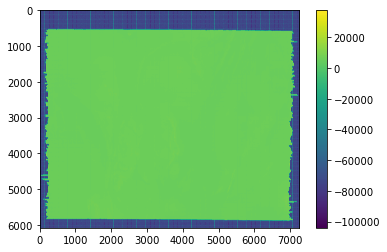

In [13]:
plt.imshow(tifffile.imread("data/inference/P565-grid-tmi_super_resolved_SR_RDN.tif"))
plt.colorbar()


In [ ]:
def simple_inference(
    lr_raster_path,
    title,
    RDN_sr_gen,
    ESRGANp_sr_gen,
    num_sr_outputs: int = 1,
    fiddle=False,
):
    lr_raster_path = Path(lr_raster_path)
    raster = tifffile.imread(lr_raster_path)
    if fiddle:
        # Deal with wildly out-of-range values (e.g. IGRF not removed)
        nan_val = -9999  # For my current survey
        raster[raster == nan_val] = np.nan
        avg = np.nanmean(raster)
        raster = raster - avg
        raster[np.isnan(raster)] = avg

    for i in range(num_sr_outputs):
        tensor_raster = torch.from_numpy(
            transform(raster).astype(np.float32)
        ).unsqueeze(0)
        tensor_raster = T.RandomCrop(32)(tensor_raster).unsqueeze(0).to(device)
        rdn_sr = RDN_sr_gen(tensor_raster).detach().to("cpu").squeeze().numpy()
        egp_sr = ESRGANp_sr_gen(tensor_raster).detach().to("cpu").squeeze().numpy()

        hr = None
        lr = tensor_raster.to("cpu")
        us = inverse_transform(upscale(lr, us_method="bicubic").squeeze().numpy())
        lr = inverse_transform(lr.squeeze().numpy())
        rdn_sr = inverse_transform(rdn_sr)
        egp_sr = inverse_transform(egp_sr)

        plot_vis_comp(lr, us, rdn_sr, egp_sr, hr, lr_only=True, figname=f"{title}_{i}")


In [ ]:
lr_raster_path = Path("/home/luke/srgeo/data_inference/P726-grid-tmi_80m.tif")
title = lr_raster_path.stem
simple_inference(lr_raster_path, title, RDN_sr_gen, ESRGANp_sr_gen, 1, fiddle=True)


In [ ]:
# lr_raster_path = Path("/home/luke/srgeo/Luke Smith - cool guy.tif")
# lr_raster_path = Path("/home/luke/srgeo/data_inference/HR_20_inference.tif")

title = "NSW 80 m Inference Visual Comparisons_50k"
lr_raster_path = "/home/luke/srgeo/data_inference/nsw_80m_crop.tif"
simple_inference(lr_raster_path, title, RDN_sr_gen, ESRGANp_sr_gen, 1)


In [ ]:
title = "WA site 3 Simple Inference Visual Comparisons_50k"
lr_raster_path = "/home/luke/srgeo/data_inference/test_site_3.tif"
simple_inference(lr_raster_path, title, RDN_sr_gen, ESRGANp_sr_gen, 1)


In [ ]:
full_extent_inference(
    Path("/home/luke/srgeo/data_inference/80m_WA_EGS_test5.tif"),
    ESRGANp_sr_gen,
    suffix="EGP",
    out_dir="figures/SR",
    batch_size=8,
)


In [ ]:
# Use RDN
# full_extent_inference(Path("/home/luke/srgeo/data_inference/80m_WA_EGS_test5.tif"), RDN_sr_gen, suffix="RDN")


In [ ]:
# SR an SR raster
# full_extent_inference(Path("/home/luke/srgeo/80m_WA_EGS_test5_super_resolved_EGP.tif"), ESRGANp_sr_gen, res=5, suffix="EGP_8x")


In [ ]:
# Check normalised value discrepancies
# When we load from the dataset, the input is transformed.
# We check here the original input data, compared against the inverse normalised, normalised data.
# Some slight difference is expected, since I rounded the min and max stats (to be strictly in desired range)
plt.figure(figsize=(9, 2))
plt.subplot(1, 3, 1)
plt.imshow(lr_sr1)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(
    np.load(
        "/home/luke/srgeo/data_train/HR_20m_LR_80m_train_val_test/test/LR_tiles.npy"
    )[sample_tile_index][0]
)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(
    lr_sr1
    - np.load(
        "/home/luke/srgeo/data_train/HR_20m_LR_80m_train_val_test/test/LR_tiles.npy"
    )[sample_tile_index][0]
)
plt.colorbar()


## Visual comparison of LR, US, SR, and HR tiles, with colourmap

## Difference comparison HR:US and HR:SR

In [ ]:
figname = f"Tile {sample_tile_index} Difference plots"
hrrdn_sr = hr_sr1 - rdn_sr1
hregp_sr = hr_sr1 - egp_sr1
hrus = hr_sr1 - us_sr1
ma = max(hrus.max(), hrrdn_sr.max())
mi = min(hrus.min(), hrrdn_sr.min(), -abs(ma))  # Center 0
ma = max(ma, abs(mi))

fig, [ax_hrus, ax_hrrdn_sr, ax_hregp_sr] = plt.subplots(
    1, 3, sharex=True, sharey=True, figsize=[15, 5]
)
plt.suptitle(figname)
ax_args = {
    "cmap": cc.cm.CET_D1,
    "vmin": mi,
    "vmax": ma,
    "interpolation": "antialiased",
}

cb1 = ax_hrus.imshow(hrus, **ax_args)
cb2 = ax_hrrdn_sr.imshow(hrrdn_sr, **ax_args)
cb3 = ax_hregp_sr.imshow(hregp_sr, **ax_args)
ax_hrus.title.set_text(f"HR - US RMSE: {np.sqrt(np.mean(hrus**2)):.2f}")
ax_hrrdn_sr.title.set_text(f"HR - RDN_SR RMSE: {np.sqrt(np.mean(hrrdn_sr**2)):.2f}")
ax_hregp_sr.title.set_text(f"HR - EGP_SR RMSE: {np.sqrt(np.mean(hregp_sr**2)):.2f}")

divider1 = mplax(ax_hrus)
divider2 = mplax(ax_hrrdn_sr)
divider3 = mplax(ax_hregp_sr)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cb1, cax=cax1)
plt.colorbar(cb2, cax=cax2)
plt.colorbar(cb3, cax=cax3)

plt.savefig(out_dir / figname)


## High Pass filtered Magnetic TMI

In [ ]:
figname = f"Tile {sample_tile_index} High Pass Filtered"
filt = fft.fftshift(create_filter(d=8, N=8, btype="high"))
lr_filt = fft.fftshift(create_filter(tile_size=32, d=8, N=8, btype="high"))

hr_f = fft.fftshift(fft.fft2(hr_sr1))
lr_f = fft.fftshift(fft.fft2(lr_sr1))
rdn_sr_f = fft.fftshift(fft.fft2(rdn_sr1))
egp_sr_f = fft.fftshift(fft.fft2(egp_sr1))
us_f = fft.fftshift(fft.fft2(us_sr1))

f_hrf = hr_f * filt
f_lrf = lr_f * lr_filt
f_rdn_srf = rdn_sr_f * filt
f_egp_srf = egp_sr_f * filt
f_usf = us_f * filt

fig, [[ax_lr, ax_off, ax_hr], [ax_us, ax_rdn_sr, ax_egp_sr]] = plt.subplots(
    2, 3, sharex=False, sharey=False, figsize=[15, 10]
)
plt.suptitle(figname)
ax_args = {
    "cmap": cc.cm.CET_L1,
    "interpolation": "antialiased",
}

ax_hr.imshow(fft.ifft2(fft.ifftshift(f_hrf)).real, **ax_args)
ax_lr.imshow(fft.ifft2(fft.ifftshift(f_lrf)).real, **ax_args)
cb_rdn_sr = ax_rdn_sr.imshow(fft.ifft2(fft.ifftshift(f_rdn_srf)).real, **ax_args)
cb_egp_sr = ax_egp_sr.imshow(fft.ifft2(fft.ifftshift(f_egp_srf)).real, **ax_args)
cb_us = ax_us.imshow(fft.ifft2(fft.ifftshift(f_usf)).real, **ax_args)

ax_hr.title.set_text("HR")
ax_lr.title.set_text("LR")
ax_rdn_sr.title.set_text("rdn_SR")
ax_egp_sr.title.set_text("egp_SR")
ax_us.title.set_text("US")

divider_rdn_sr = mplax(ax_rdn_sr)
caxrdn_sr = divider_rdn_sr.append_axes("right", size="5%", pad=0.5)
plt.colorbar(cb_rdn_sr, cax=caxrdn_sr)
divider_us = mplax(ax_us)
caxus = divider_us.append_axes("right", size="5%", pad=0.5)
plt.colorbar(cb_us, cax=caxus)

plt.savefig(out_dir / figname)

plt.figure()
plt.imshow((fft.ifft2(fft.ifftshift(f_rdn_srf)) - fft.ifft2(fft.ifftshift(f_usf))).real)


## Power Spectra
Comparison of energy in high frequencies between low resolution input, upscaled, super resolved, and high resolution.
We hope to see increased energy in the Super Resolved spectra.

In [ ]:
# # def plot_power_spectrum(in_t, in_t_res=20):

# # Source Image
# in_t = hr
# in_t_res = 20
# h, w = in_t.shape

# #2D PSD norm

# #2D PSD Shifted

# #Radially averaged PSD


# tf = fft.fftshift(fft.fft2(in_t))
# tfp = np.abs(tf) / (h*w)**2
# kfreq = np.fft.fftfreq(h, in_t_res)
# x, y = np.meshgrid(kfreq, kfreq)


# plt.loglog(x,y)


In [ ]:
from sklearn.preprocessing import PowerTransformer

pt_norm = PowerTransformer(method="yeo-johnson")
pt_norm.fit(dataarray.squeeze().reshape(-1, 1))
pt_hr = pt_norm.transform(dataarray.squeeze().reshape(-1, 1)).reshape(128, 128)
pt_lr = pt_norm.transform(dataarray.squeeze().reshape(-1, 1)).reshape(32, 32)


plt.figure()
plt.hist(pt_hr.flatten(), bins=100, label="hr")
plt.hist(pt_lr.flatten(), bins=100, label="lr")
plt.legend()
plt.axhline(100, c="r")
# plt.yscale("log")

plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(pt_hr, interpolation="nearest")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(dataarray[0][0], interpolation="nearest")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(
    pt_norm.inverse_transform(pt_hr.reshape(-1, 1)).reshape(128, 128),
    interpolation="nearest",
)  #  - input_lr[0][0])
plt.colorbar()


In [ ]:
# aarr = np.argsort(dataarray.flatten())
# print("Max", input_lr.flatten()[aarr[-1]])
# print("Min", input_lr.flatten()[aarr[0]])
# print("mean + 3 std", input_hr.flatten().mean() + 3 * input_hr.flatten().std())
# print("mean - 3 std", input_hr.flatten().mean() - 3 * input_hr.flatten().std())

plt.figure()
plt.hist(input_hr.flatten(), bins=100, label="hr")
plt.hist(input_lr.flatten(), bins=100, label="lr")
plt.legend()
# plt.axhline(100, c='r')
plt.axvline(input_hr.flatten().mean(), c="k")
plt.axvline(input_hr.flatten().mean() + 3 * input_hr.flatten().std(), c="g")
plt.axvline(input_hr.flatten().mean() - 3 * input_hr.flatten().std(), c="g")
plt.yscale("log")


In [ ]:
# if norm_type == "yeo_johnson":
#     # Define normalisation and inverse transform for Yeo Johnson Power Transformer.
#     import scipy.stats
#     import sklearn.preprocessing._data
#     inv_yj = sklearn.preprocessing._data.PowerTransformer._yeo_johnson_inverse_transform
#     ma = test_dataset.stats["yj_max"]
#     mi = test_dataset.stats["yj_min"]
#     l  = test_dataset.stats["lambda"]

#     transform = lambda i: ((scipy.stats.yeojohnson(i, lmbda=l) - mi) / (ma - mi)) * 2 - 1
#     inverse_transform = lambda ni: inv_yj(None, (((ni + 1) / 2) * (ma - mi)) + mi, l)
#     # unshift = lambda t: ((t + 1) /  2)        # undo shift min max to -1, 1
#     # unscale = lambda t: (t * (ma - mi)) + mi  # undo min max to 0, 1
#     # untrsfm = lambda t: inv_yj(None, t, l)    # undo YJ power transform


In [ ]:
## Unfold inference

# lr_raster_path = Path("/home/luke/srgeo/data_inference/HR_20_inference.tif")
# raster = tifffile.imread(lr_raster_path)
# tensor_raster = torch.from_numpy(transform(raster))

# t = tensor_raster.unfold(0,32,32).unfold(1, 32, 32)
# patches = t.contiguous().view(-1, 32, 32)
# old_shape = patches.size()

# patches_orig = patches.view(old_shape)
# new_shape_h = old_shape[0] * old_shape[2]
# new_shape_w = old_shape[1] * old_shape[3]
# patches_orig = patches_orig.permute(0, 2, 1, 3).contiguous()

# patches_orig = patches_orig.view(new_shape_h, new_shape_w)


# (tensor_raster == patches_orig).all()


In [ ]:
# ## Check if input gives same output always

# s1 = ESRGANp_sr_gen(test_dataset[sample_tile_index]["lr"].to(device).unsqueeze(0)).detach().to("cpu").squeeze().numpy()
# s2 = ESRGANp_sr_gen(test_dataset[sample_tile_index]["lr"].to(device).unsqueeze(0)).detach().to("cpu").squeeze().numpy()
# s3 = ESRGANp_sr_gen(test_dataset[sample_tile_index]["lr"].to(device).unsqueeze(0)).detach().to("cpu").squeeze().numpy()
# s4 = ESRGANp_sr_gen(test_dataset[sample_tile_index]["lr"].to(device).unsqueeze(0)).detach().to("cpu").squeeze().numpy()

# print("All same:", ((s1 == s2).all() and (s2 == s3).all() and (s3 == s4).all()))
# plt.figure(figsize=(10,15))
# fig, [[a,b],[c,d]] = plt.subplots(2,2)
# a.imshow(s1-s2)
# a.title.set_text(f"{np.mean(s1-s2):.5f}")
# b.imshow(s2-s3)
# b.title.set_text(f"{np.mean(s2-s3):.5f}")
# c.imshow(s3-s4)
# c.title.set_text(f"{np.mean(s3-s4):.5f}")
# d.imshow(s4-s1)
# d.title.set_text(f"{np.mean(s4-s1):.5f}")
